<a href="https://colab.research.google.com/github/steed360/Data-Analysis/blob/main/a_Regression_Errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create charts to illustrate and better understand which distributions of Y will produce linear regression models that satisfy the "regression assumptions", including:

- Error terms will be normally distributed
- Same std deviation for the error term regardless of position along X

Method:

Part One:

- Firstly start with a fitted model (calculating height for a given weight)
- Plot the regression line and the error distribution for a few points X
- Generate data for each xi,
  i.e. create normal distributions for yi~N( mean = + 154cm + weight * slope , std= 4)
- In this simple example regression could be seen as basicaly a few conditional Normal Distributions
- Show the distribution of the "dataset" would have so perfectly met these regression assumptions.
- Specifically gather the data sampled from Normal (Y1) Normal (Y2) etc into one array and show what distribution we get.  Is it Normally Distributed?

Part Two:

- Positively skewed data with long tails includes income data, travel data, survival times.
- Books warn that trying to explain such data with a regression model is likely to break the constant error variance "regression assumption"
- Repeat the data sampling in Part One (again sample from the regression equation)
- This time increase the variance for the last two points.
- Again, collect the conditional data sampled from each Xi and throw it all into one array.
- What is the shape of the distribution of the Y data?


In [318]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import plotnine
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/

import matplotlib

%matplotlib inline
from mizani import formatters # for better axis labelling
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Rectangle


In [319]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [320]:
# configure plot font family to Arial
#plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
#matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

In [321]:
# Specify the chart layout (PowerBI all is forgiven.... :)

def SWD_theme ():

    font = "Arial" # doesn't work on Colab
    #t=theme_minimal(base_size = 10, base_family = font )
    t=theme_minimal(base_size = 10 )

    t2 = theme(
      #panel_grid_major = element_blank(),
      panel_grid_minor = element_line(size = 0.5, color = GRAY9),

      #panel_grid_minor = element_blank(),
      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),
      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
      axis_title = element_text(color = GRAY3),
      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),
      plot_title = element_text(color = GRAY4, size= 12 ),
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",
      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      #plot_margin = (0.4 ),
      strip_text = element_text(color = GRAY7))

    return t+ t2

# Part One

#### Sample from the normal distribution for each of the four points, specifically sample from N ( mu = 30, s= 5), N (mu=40, s=5) etc

In [322]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)


# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.


b_weight_kg = 0.9
c_avg_height_cm = 154
sd = 5.0  # standard deviation of errors.

dictYi = {}

for xi in lst_x:
  dictYi[xi] = c_avg_height_cm  + b_weight_kg * xi

dictYi


{20: 172.0, 30: 181.0, 40: 190.0, 50: 199.0}

In [323]:
#####################################
# A simple data frame is needed to do a line chart
###################################

lst_Yi = [dictYi[xi] for xi in dictYi.keys() ]

data_x_y = pd.DataFrame ( {'x':lst_x,'y':lst_Yi})
data_x_y
# Currently doing this as a categorical variable because the violin plot requires a categorical X Axis
data_x_y['variable'] = data_x_y['x'].astype(pdtypes.CategoricalDtype(categories=[20,30,40,50]))
data_x_y['group'] = 1

data_x_y

,x,y,variable,group
0,20,172.0,20,1
1,30,181.0,30,1
2,40,190.0,40,1
3,50,199.0,50,1


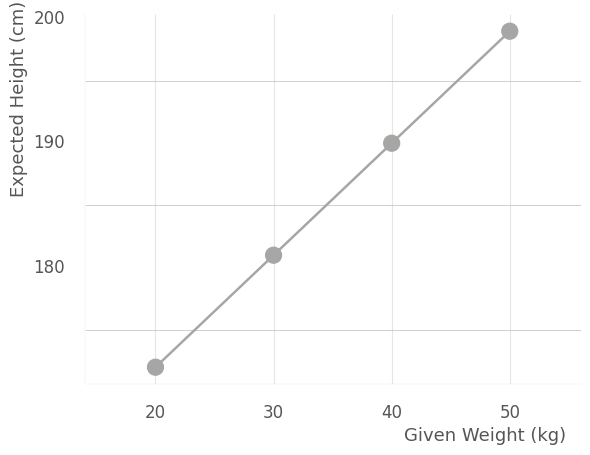

<ggplot: (8281299204709)>

In [324]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.75),
          panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

fig = \
(ggplot()
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)    "  , x = "Given Weight (kg)")
  +  SWD_theme() + t

)

fig

Sample from the 4 normal distributions (specifing a constant st dev of 5 cm)

In [325]:
dictYi

{20: 172.0, 30: 181.0, 40: 190.0, 50: 199.0}

In [326]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)


# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.


b_weight_kg = 0.9
c_avg_height_cm = 154
sd = 5.0  # standard deviation of errors.


N = 100000              # Number of data points to generate.

# Create a dataframe (with x as columns and yi~N() samples as rows)

df = pd.DataFrame()

for xi in lst_x:
    yi = dictYi[xi]
    df[xi] = stats.norm.rvs(yi , 5, N)

###################################

# A long version of this dataframe is needed for plotting as violin plots
import pandas.api.types as pdtypes # for (sorted) categories.
df_long = pd.melt(df,value_vars=[20,30,40,50]  )
df_long['variable'] = df_long['variable'].astype(pdtypes.CategoricalDtype(categories=[10,20,30,40,50,60]))




Do violin plot

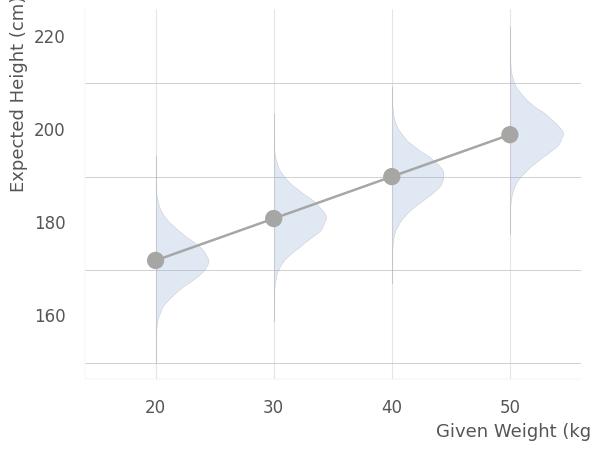

<ggplot: (8281299413629)>

In [327]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.8),
          panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

m1 = aes(x=stage('variable', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('variable', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('variable', after_scale='x+shift_point*x' ),y='vals' )

fig = \
(ggplot(df_long, aes('variable', 'value',group = 'variable'))
  + geom_violin( alpha=0.3, color=GRAY8, fill=BLUE3, style="right", size=lsize)
  #+ geom_point(m2, alpha=0.005, color=GRAY8,size=0.2)
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)


fig

<Axes: >

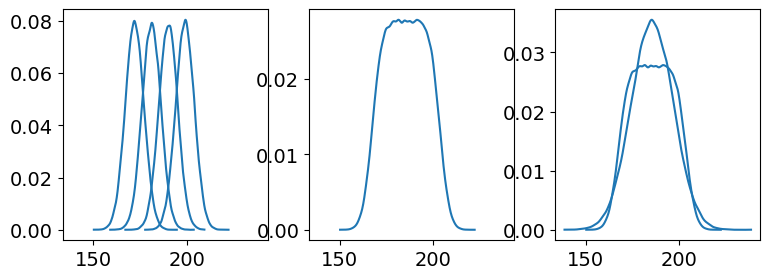

In [328]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)


# Plot the individual conditional distributions that have been just shown
# in the violin plot above
for thisX in lst_x:
    az.plot_kde (df[thisX], ax = axs[0])

# Now plot the result of sampling from each of across each these distributions at once.
az.plot_kde  ( df_long['value'] , ax = axs[1])

# The resulting distribution is quite wide.
# Find the mean and standard deviation in order to give a comparison.


std1 = np.std (df_long['value'] )
mu1  = np.mean (df_long['value'] )
# Repeat the distribution for the data sampled from across the 4 conditional normal dists
az.plot_kde  ( df_long['value'] , ax = axs[2])
# And add the properly shaped normal one just defined
az.plot_kde  ( stats.norm.rvs( mu1 ,std1, N), ax=axs[2] )


## So in summary
### In this case the data that created a "perfect" linear model was not a normal distribution. The distribution is a bit wider (like a T-Distrbution?).  However, it is worth nothing that there was also no skew in the originating distribution.

# Part 2

As before Sample from the 4 Normal Distributions but this time
- The std. dev. for esimated height is still 5 at 20&30 kg
- But the std. dev. for esimated height is 10 at 40&50 kg


In [329]:
# Specify some x values.
lst_x =  [i for i in range ( 20,60, 10)]
np_x = np.array ( lst_x)


# Produce some Yi values using
# a model of height = function (weight) from Statistical Rethinking
# Place in a dict for later retrieval.

b_weight_kg = 0.9
c_avg_height_cm = 154
sd = 5.0  # standard deviation of errors.


N = 100000              # Number of data points to generate.

# Create a dataframe (with x as columns and yi~N() samples as rows)

df = pd.DataFrame()

for xi in lst_x:
    yi = dictYi[xi]
    if xi <= 30:
      df[xi] = stats.norm.rvs(yi , 5, N)
    else:
      df[xi] = stats.norm.rvs(yi , 10, N)

###################################

# A long version of this dataframe is needed for plotting as violin plots
import pandas.api.types as pdtypes # for (sorted) categories.
df_long = pd.melt(df,value_vars=[20,30,40,50]  )
df_long['variable'] = df_long['variable'].astype(pdtypes.CategoricalDtype(categories=[10,20,30,40,50,60]))



Redo the violin plot

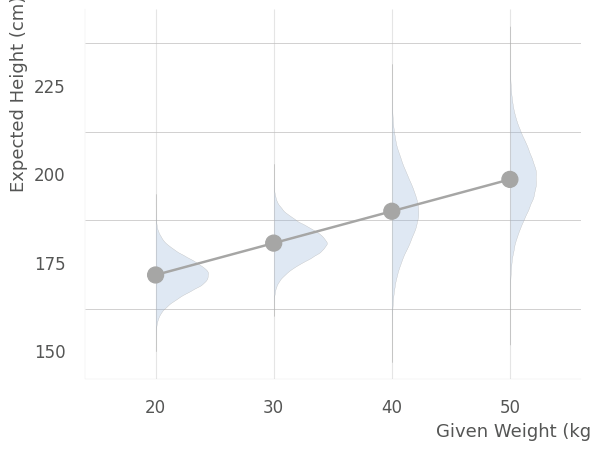

<ggplot: (8281298843024)>

In [330]:
from plotnine import geom_violin
from plotnine import ggplot, aes

t = theme(
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 13, color = GRAY3, y = 0.5),
          axis_title_x = element_text(  size = 13, color = GRAY3, x=0.8),
          panel_grid_major_y=element_blank(),
          legend_position="none"
)

lsize = 0.1
shift = -0.06
shift_point = 0.07

# For shifting the violin plot
def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    #return (-1) ** x
    return

m1 = aes(x=stage('variable', after_scale='x+shift*x'))                 # shift outward
m2 = aes(x=stage('variable', after_scale='x+shift_point*x'))           # shift outward
m3 = aes( stage('variable', after_scale='x+shift_point*x' ),y='vals' )

fig = \
(ggplot(df_long, aes('variable', 'value',group = 'variable'))
  + geom_violin( alpha=0.3, color=GRAY8, fill=BLUE3, style="right", size=lsize)
  #+ geom_point(m2, alpha=0.005, color=GRAY8,size=0.2)
  + geom_line (data_x_y,aes( x='variable', y='y', group = 'group', size=2),color=GRAY8 )
  + geom_point (data_x_y, aes( x='variable', y='y',size=10), color=GRAY8 )
  + labs(y = "Expected Height (cm)     "  , x = "Given Weight (kg)")
  +SWD_theme() + t
)


fig

<Axes: >

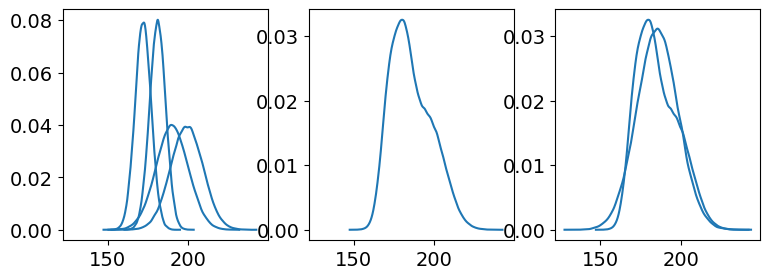

In [331]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)


# Plot the individual conditional distributions that have been just shown
# in the violin plot above
for thisX in lst_x:
    az.plot_kde (df[thisX], ax = axs[0])

# Now plot the result of sampling from each of across each these distributions at once.
az.plot_kde  ( df_long['value'] , ax = axs[1])

# The resulting distribution is quite wide.
# Find the mean and standard deviation in order to give a comparison.


std1 = np.std (df_long['value'] )
mu1  = np.mean (df_long['value'] )
# Repeat the distribution for the data sampled from across the 4 conditional normal dists
az.plot_kde  ( df_long['value'] , ax = axs[2])
# And add the properly shaped normal one just defined
az.plot_kde  ( stats.norm.rvs( mu1 ,std1, N), ax=axs[2] )


## So in summary
#### The originating distribution for height is definately a little skewed to the right.  Does this really tell us anything though?